In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from functions import *
from boruta import BorutaPy
from skbio.stats.distance import permanova, DistanceMatrix
# import xgboost as xgb

**DRA008156 Prediction**

In [37]:
# Load the clustered DRA008156 data
abundance_data_clustered = pd.read_csv('../../data/clustering/humann_clustered/clustered_complete_DRA008156.tsv', sep='\t')
abundance_data_raw = pd.read_feather('/Users/odesa/Library/CloudStorage/OneDrive-UniversityofToronto/LabWork/CRC/LatestDataJan/DRA008156/clean_joined_genefamilies_relab_DRA008156.feather')

meta_data = pd.read_feather('/Users/odesa/Library/CloudStorage/OneDrive-UniversityofToronto/LabWork/CRC/LatestDataJan/DRA008156/DRA008156_metadata_complete.feather')

In [38]:
abundance_data_grouped = group_humann_table(abundance_data_raw)

/Users/odesa/Documents/CRC-Final/src/clustering/functions.py:261: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_df = humann_df.groupby(humann_df.columns, axis=1).sum()


Original width: 102465, Grouped width: 13


In [52]:
print(abundance_data_grouped.shape)
print(abundance_data_clustered.shape)
print(abundance_data_raw.shape)

(555, 13)
(555, 1655)
(555, 102465)


In [40]:
meta_data = meta_data[meta_data['Accession'].isin(abundance_data_grouped['sample'])]

In [41]:
meta_data = meta_data[['Accession', 'Group']]

meta_data = meta_data.rename(columns={'Accession': 'sample'})

In [42]:
df = pd.merge(abundance_data_grouped, meta_data, on='sample', how='inner')

# Separate features and target
X = df.drop(['Group', 'sample'], axis=1)
y = df['Group']

In [43]:
# Split the abundance data into training, testing, and validation sets (70/20/10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify labels

print(X_train.shape)
print(X_test.shape)



(444, 12)
(111, 12)


In [44]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

# Best params for raw data : Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
# Best params for grouped data: Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

In [45]:
# Create and train the model
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Predict the probabilities for the test set
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Get the probability of class 1

In [46]:
# Check the order of the classes
class_order = rf_model.classes_
print("Class order in model:", class_order)

# Make predictions on the test set
y_prob = rf_model.predict_proba(X_test)

# If 'Cancer' is the second class in the order, for instance
if class_order[1] == 'Cancer':
    y_prob_cancer = y_prob[:, 1]  # Get the probability of 'Cancer'
else:
    y_prob_cancer = y_prob[:, 0]  # If 'Cancer' is the first class


Class order in model: ['Cancer' 'Healthy']


In [48]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='Cancer')
y_test_encoded = [1 if label == 'Cancer' else 0 for label in y_test]
roc_auc = roc_auc_score(y_test_encoded, y_prob_cancer)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.5315315315315315
F1 Score: 0.44680851063829785
ROC AUC: 0.5074061882817643


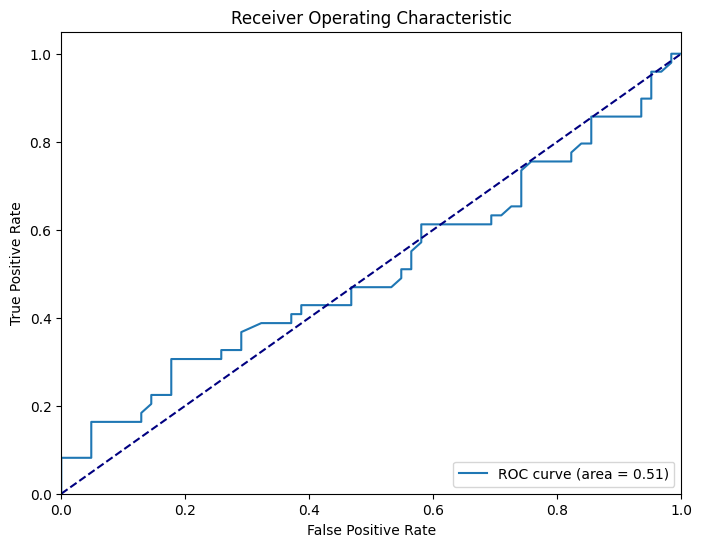

In [49]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_prob_cancer)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('DRA008156_grouped_roc_curve.png', dpi=600)

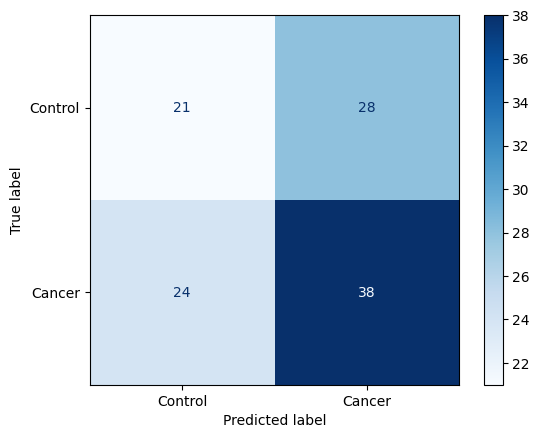

In [50]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = ['Control', 'Cancer']


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('DRA008156_grouped_confusion_matrix.png', dpi=600)

In [29]:

feature_importances = rf_model.feature_importances_

feature_names = X_train.columns

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 important features
print(importances_df.head(10))

                             Feature  Importance
233                    unclustered.3    0.009109
1126           Muramidase-A0A1W6LMA8    0.008799
704               Amidase-A0A3P1V5J5    0.008242
560               Amidase-A0A1W7ABN8    0.008041
782               Amidase-A0A535X4W3    0.007658
361   DD-carboxypeptidase-A0A535ERD0    0.006826
703               Amidase-A0A3N5B293    0.006673
1418           Muramidase-A0A561DCD8    0.006125
380   DD-carboxypeptidase-A0A7C5DJG4    0.006082
899               Amidase-A0A841PWQ3    0.005636


In [ ]:
# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))

plt.title('Top 20 Feature Importances in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

**PRJEB7774 Prediction**

In [3]:
# Load the clustered DRA008156 data
clustered_abundance_data_7774 = pd.read_csv('../../data/clustering/humann_clustered/clustered_complete_PRJEB7774.tsv', sep='\t')

abundance_data_7774 = pd.read_feather('C:\\Users\\odesa\\OneDrive - University of Toronto\\LabWork\\CRC\\LatestDataJan\\PRJEB7774\\clean_joined_genefamilies_relab_7774.feather')

meta_data_7774 = pd.read_feather('C:\\Users\\odesa\\OneDrive - University of Toronto\\labWork\\CRC\\LatestDataJan\\PRJEB7774\\PRJEB7774_metadata.feather')

In [4]:
meta_data_7774['sample_title'].value_counts()

print(abundance_data_7774.head())

# Gene Family  sample_id  UNMAPPED  Amidase_UniRef100_A0A015SN82  \
0              ERR688505  0.994337                  6.761060e-08   
1              ERR688506  0.995306                  1.862910e-08   
2              ERR688507  0.995279                  8.390840e-09   
3              ERR688508  0.995857                  2.620490e-08   
4              ERR688509  0.995031                  0.000000e+00   

# Gene Family  Amidase_UniRef100_A0A015SSH9  Amidase_UniRef100_A0A015SVI2  \
0                              0.000000e+00                           0.0   
1                              0.000000e+00                           0.0   
2                              0.000000e+00                           0.0   
3                              1.006710e-08                           0.0   
4                              0.000000e+00                           0.0   

# Gene Family  Amidase_UniRef100_A0A015T2F2  Amidase_UniRef100_A0A015T8Q8  \
0                              7.149150e-08        

In [5]:
meta_data_7774 = meta_data_7774[meta_data_7774['run_accession'].isin(abundance_data_7774['sample_id'])]

meta_data_7774 = meta_data_7774.rename(columns={'run_accession': 'sample_id'})

df_7774 = pd.merge(abundance_data_7774, meta_data_7774, on='sample_id')

In [6]:
df_7774['sample_title'] = df_7774['sample_title'].replace({'Control': 0, 'Adenoma': 0, 'Carcinoma': 1})


In [7]:
# Separate features and target
X = df_7774.drop(['sample_title', 'sample_id'], axis=1)
y = df_7774['sample_title']

In [39]:
# Check data types of all columns
print(X.dtypes)

# Identify columns of 'object' data type
object_columns = X.select_dtypes(include=['object']).columns
print("Columns with object data type:", object_columns)

# For each object column, check unique values to understand the mix of data
for col in object_columns:
    print(f"Unique values in '{col}':", X[col].unique())

UNMAPPED                        float64
Amidase_UniRef100_A0A015SN82    float64
Amidase_UniRef100_A0A015SSH9    float64
Amidase_UniRef100_A0A015SVI2    float64
Amidase_UniRef100_A0A015T2F2    float64
                                 ...   
UC118_WP_253005939.1            float64
UC118_WP_255820014.1            float64
UC118_WP_263296879.1            float64
UC118_WP_263297069.1            float64
UC118_WP_263298109.1            float64
Length: 80748, dtype: object
Columns with object data type: Index([], dtype='object')


In [8]:
# Split the abundance data into training, testing, and validation sets (70/20/10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify labels

print(X_train.shape)
print(X_test.shape)

(108, 80748)
(47, 80748)


In [25]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

# Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [15]:
best_params =  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Create and train the model
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Predict the probabilities for the test set
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Get the probability of class 1

In [16]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.7659574468085106
F1 Score: 0.4210526315789473
ROC AUC: 0.7727272727272727


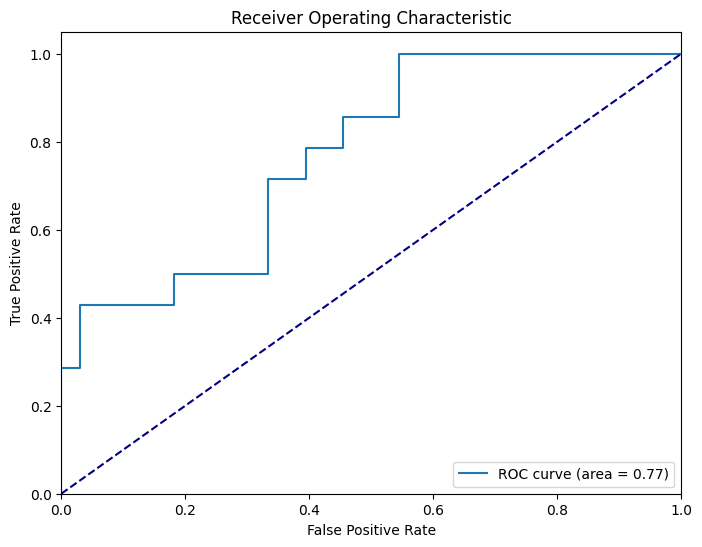

In [17]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../../figures/PRJEB7774_noCluster_roc_curve.png', dpi=300)

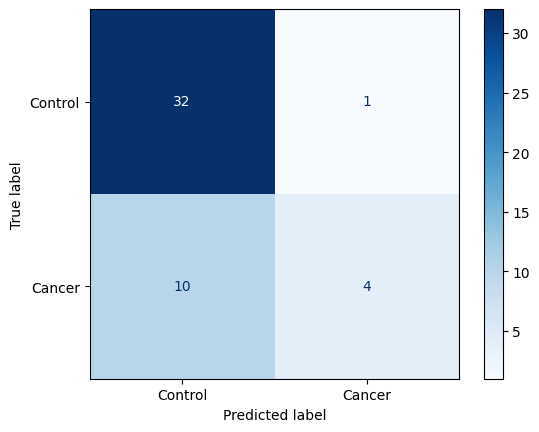

In [18]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = ['Control', 'Cancer']


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('PRJEB7774_cluster_confusion_matrix.png', dpi=300)

In [20]:
column_names = abundance_data_7774.columns

column_names = [name.split('_')[0] for name in column_names]

abundance_data_7774.columns = column_names



      sample  UNMAPPED       Amidase       Amidase  Amidase       Amidase  \
0  ERR688505  0.994337  6.761060e-08  0.000000e+00      0.0  7.149150e-08   
1  ERR688506  0.995306  1.862910e-08  0.000000e+00      0.0  1.957540e-08   
2  ERR688507  0.995279  8.390840e-09  0.000000e+00      0.0  9.599790e-09   
3  ERR688508  0.995857  2.620490e-08  1.006710e-08      0.0  2.771230e-08   
4  ERR688509  0.995031  0.000000e+00  0.000000e+00      0.0  0.000000e+00   

        Amidase       Amidase       Amidase       Amidase  ...  UC118  UC118  \
0  3.498540e-07  0.000000e+00  0.000000e+00  0.000000e+00  ...    0.0    0.0   
1  2.265330e-07  0.000000e+00  0.000000e+00  0.000000e+00  ...    0.0    0.0   
2  1.268340e-07  0.000000e+00  3.218900e-07  0.000000e+00  ...    0.0    0.0   
3  1.494020e-07  1.090470e-08  0.000000e+00  1.087780e-08  ...    0.0    0.0   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...    0.0    0.0   

   UC118  UC118  UC118  UC118  UC118  UC118  UC118  UC11

In [21]:
df_combined = abundance_data_7774.groupby(by=abundance_data_7774.columns, axis=1).sum()

print(df_combined.head())

# rename the sample column


C:\Users\odesa\AppData\Local\Temp\ipykernel_12396\2079883723.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_combined = abundance_data_7774.groupby(by=abundance_data_7774.columns, axis=1).sum()


    Amidase  DD-carboxypeptidase  DD-endopeptidase  DL-endopeptidase  \
0  0.001340             0.001220          0.000204          0.000597   
1  0.001213             0.001103          0.000086          0.000448   
2  0.001110             0.001140          0.000164          0.000475   
3  0.001146             0.000882          0.000095          0.000330   
4  0.001151             0.001430          0.000098          0.000478   

   Diadenylate  Glucosaminidase  LD-carboxypeptidase  LD-endopeptidase  \
0     0.000266         0.000298             0.000161          0.000006   
1     0.000267         0.000246             0.000144          0.000015   
2     0.000273         0.000302             0.000120          0.000023   
3     0.000308         0.000380             0.000137          0.000008   
4     0.000289         0.000215             0.000115          0.000005   

   Muramidase  UC118  UNMAPPED     sample  
0    0.001571    0.0  0.994337  ERR688505  
1    0.001173    0.0  0.995306  ER

In [24]:
df_combined = df_combined.rename(columns={'sample': 'sample_id'})

**ML Testing on IBD patient Data**

In [4]:
clustered_abundance_ibd = pd.read_csv('/Volumes/PGH-Backup/ibd_data/humann_second_run/ibd_genefamilies_relab_clustered.tsv', sep='\t')

ibd_metadata = pd.read_csv('/Volumes/PGH-Backup/ibd_data/hmp2_metadata_2018-08-20.csv')

display(clustered_abundance_ibd.head())

/var/folders/sm/rgfxp6g94f18340p2rvqnsc00000gn/T/ipykernel_89511/809341487.py:3: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  ibd_metadata = pd.read_csv('/Volumes/PGH-Backup/ibd_data/hmp2_metadata_2018-08-20.csv')


,Unnamed: 0,DL-endopeptidase-A0A0B0HUJ2,DL-endopeptidase-A0A0P8W7Z2,DL-endopeptidase-A0A132I0H7,DL-endopeptidase-A0A174CGJ4,DL-endopeptidase-A0A174M4B0,DL-endopeptidase-A0A174TDS3,DL-endopeptidase-A0A1C5KMM8,DL-endopeptidase-A0A1C5KNH6,DL-endopeptidase-A0A1C5PVP3,...,Muramidase-T0UBX6,Muramidase-T0WIP7,Muramidase-U2ECY2,Muramidase-U7D9Q6,Muramidase-V1GVJ2,Muramidase-V5EDU1,Muramidase-W4UCM7,Muramidase-W5XD20,Muramidase-W9H589,sample_id
0,0,0.000000,0.0,8.383020e-07,0.000000,1.323079e-06,0.0,0.000004,0.000003,0.000000,...,0.0,0.0,0.0,0.000145,0.0,0.0,0.0,0.0,0.0,CSM5FZ4M
1,1,0.000001,0.0,3.478880e-06,0.000002,4.373101e-06,0.0,0.000018,0.000010,0.000007,...,0.0,0.0,0.0,0.000093,0.0,0.0,0.0,0.0,0.0,CSM5MCUO
2,2,0.000000,0.0,0.000000e+00,0.000000,9.575670e-07,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000146,0.0,0.0,0.0,0.0,0.0,CSM5MCVL
3,3,0.000000,0.0,1.302237e-06,0.000000,1.704135e-06,0.0,0.000001,0.000000,0.000000,...,0.0,0.0,0.0,0.000143,0.0,0.0,0.0,0.0,0.0,CSM5MCVN
4,4,0.000000,0.0,2.120380e-06,0.000000,4.052097e-06,0.0,0.000009,0.000008,0.000000,...,0.0,0.0,0.0,0.000130,0.0,0.0,0.0,0.0,0.0,CSM5MCW6


In [5]:
display(ibd_metadata.head())

print(clustered_abundance_ibd.shape, ibd_metadata.shape)

,Project,External ID,Participant ID,site_sub_coll,data_type,week_num,date_of_receipt,interval_days,visit_num,Research Project,...,FecalCal received at MGH:,Proteomics received at LBNL:,Stool Sample ID: Tube A (EtOH),Sample ID: Tube B (No preservative),Tube A and B received at Broad:,stool_id,smoking status,Number years smoked,Age when started smoking,How many cigarettes/cigars/etc. do you smoke per day?
0,C3001CSC1_BP,206615,C3001,C3001CSC1,biopsy_16S,2.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
1,C3001CSC2_BP,206614,C3001,C3001CSC2,biopsy_16S,2.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
2,C3002CSC1_BP,206617,C3002,C3002CSC1,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
3,C3002CSC2_BP,206619,C3002,C3002CSC2,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
4,C3002CSC3_BP,206616,C3002,C3002CSC3,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN


(1337, 1417) (5533, 490)


In [6]:
clustered_abundance_ibd.drop_duplicates(subset='sample_id', inplace=True)

clustered_abundance_ibd = clustered_abundance_ibd.drop(columns=['Unnamed: 0'])

In [7]:
ibd_metadata = ibd_metadata[ibd_metadata['External ID'].isin(clustered_abundance_ibd['sample_id'])]

print(ibd_metadata.shape, clustered_abundance_ibd.shape)



(3405, 490) (1316, 1416)


In [8]:
filtered_ibd_metadata = ibd_metadata[ibd_metadata['data_type'] == 'metagenomics']

print(filtered_ibd_metadata.shape)

(1316, 490)


In [9]:
final_metadata = filtered_ibd_metadata[['External ID', 'diagnosis']]
final_metadata = final_metadata.rename(columns={'External ID': 'sample_id'})

In [10]:
merged_df = pd.merge(clustered_abundance_ibd, final_metadata, on='sample_id')

In [34]:
merged_df = pd.merge(clustered_abundance_ibd, final_metadata, on='sample_id')

X = merged_df.drop(columns=['sample_id', 'diagnosis'])  # Assuming 'diagnosis' is the column name for ground truths
y = merged_df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [35]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1052, 1415) (264, 1415) (1052,) (264,)


In [36]:
# Define the parameter grid for the Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [37]:
# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END m

In [38]:
# Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          CD       0.86      0.99      0.92       115
          UC       0.97      0.85      0.90        72
      nonIBD       1.00      0.90      0.95        77

    accuracy                           0.92       264
   macro avg       0.94      0.91      0.92       264
weighted avg       0.93      0.92      0.92       264



In [39]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[114   1   0]
 [ 11  61   0]
 [  7   1  69]]


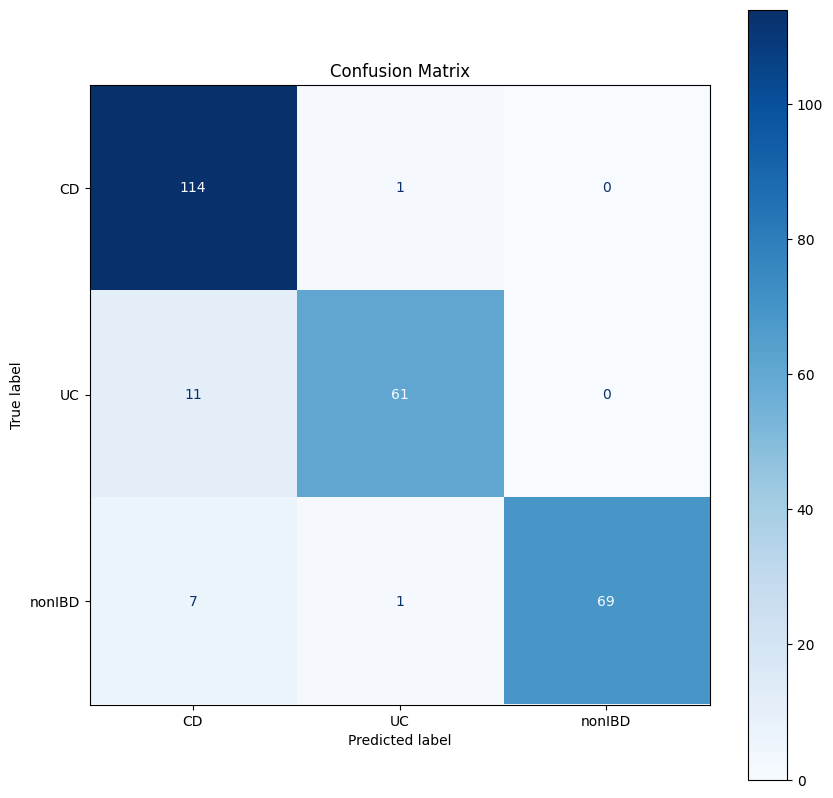

In [40]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues")
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#   precision    recall  f1-score   support

#           CD       0.87      0.98      0.92       115
#           UC       0.95      0.83      0.89        72
#       nonIBD       1.00      0.92      0.96        77

#     accuracy                           0.92       264
#    macro avg       0.94      0.91      0.92       264
# weighted avg       0.93      0.92      0.92       264

In [41]:
import joblib

# Save the model to disk
joblib.dump(best_model, '/Volumes/PGH-Backup/ibd_data/best_random_forest_model.joblib')

['/Volumes/PGH-Backup/ibd_data/best_random_forest_model.joblib']

In [43]:
# Extract feature importances from the best model
feature_importances = best_model.feature_importances_

# Get the feature names from the dataframe
feature_names = X.columns

# Create a dataframe to hold feature names and their importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Get the top 10 features overall
top_20_features = importance_df.head(20)
print("Top 20 features overall:")
print(top_20_features)



Top 20 features overall:
                             feature  importance
740               Amidase-A0A7C6ZNH3    0.014604
1045           Muramidase-A0A2Z6B1U6    0.008256
1192           Muramidase-A0A4R6XTX5    0.007886
129       Glucosaminidase-A0A2Z5VGM9    0.007190
705               Amidase-A0A656A205    0.006891
1193           Muramidase-A0A4S2AN32    0.006635
195           Glucosaminidase-W4P4D8    0.006528
62    LD-carboxypeptidase-A0A3E3E572    0.006188
1183           Muramidase-A0A4Q3MM19    0.006007
1207           Muramidase-A0A520YPY2    0.005431
966            Muramidase-A0A1W6LMA8    0.005430
119       Glucosaminidase-A0A255U393    0.005329
387       DD-carboxypeptidase-T4VPV1    0.005132
1016           Muramidase-A0A2S0KP84    0.005023
1010           Muramidase-A0A2N2ZW25    0.004753
446               Amidase-A0A193QHI5    0.004713
1261           Muramidase-A0A7C1N3A2    0.004704
995            Muramidase-A0A2D5F729    0.004662
498               Amidase-A0A220U202    0.00

**Train with DLEs only, wont work well, only 42 columns**

In [ ]:
clustered_abundance_ibd_dle = clustered_abundance_ibd.filter(like='DL-endo', axis=1)
clustered_abundance_ibd_dle['sample_id'] = clustered_abundance_ibd['sample_id']

print(clustered_abundance_ibd_dle.shape)

In [46]:
merged_df = pd.merge(clustered_abundance_ibd_dle, final_metadata, on='sample_id')

X = merged_df.drop(columns=['sample_id', 'diagnosis'])  # Assuming 'diagnosis' is the column name for ground truths
y = merged_df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Define the parameter grid for the Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

(1052, 41) (264, 41) (1052,) (264,)


In [48]:
# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END m

In [49]:
# Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          CD       0.65      0.88      0.75       115
          UC       0.84      0.53      0.65        72
      nonIBD       0.73      0.60      0.66        77

    accuracy                           0.70       264
   macro avg       0.74      0.67      0.68       264
weighted avg       0.73      0.70      0.69       264



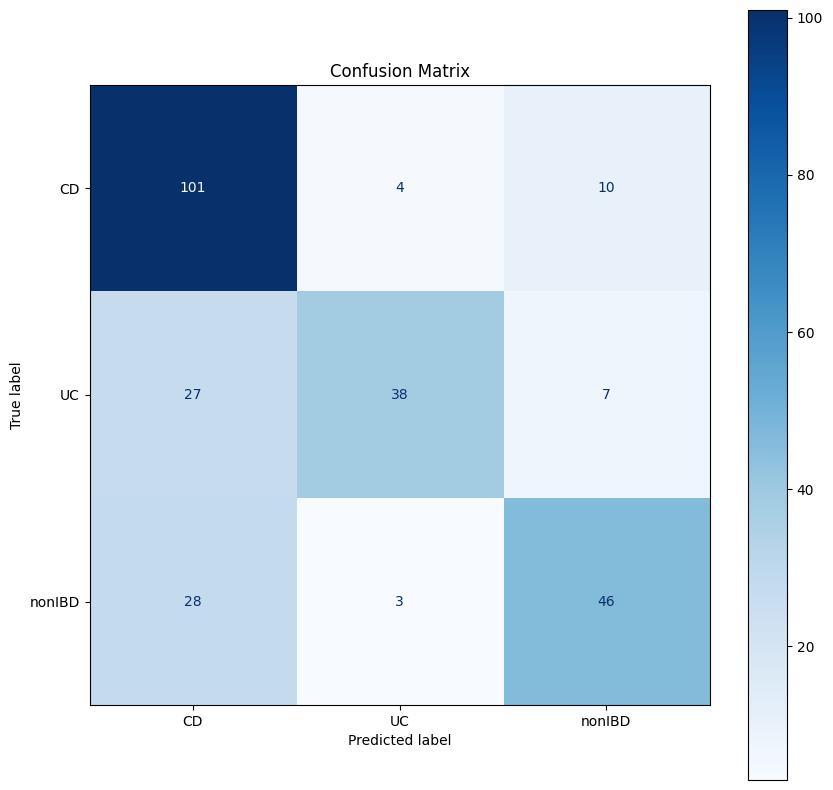

In [50]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues")
plt.title('Confusion Matrix')
plt.show()


In [51]:
# Extract feature importances from the best model
feature_importances = best_model.feature_importances_

# Get the feature names from the dataframe
feature_names = X.columns

# Create a dataframe to hold feature names and their importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Get the top 10 features overall
top_20_features = importance_df.head(20)
print("Top 20 features overall:")
print(top_20_features)


Top 20 features overall:
                        feature  importance
30  DL-endopeptidase-A0A6N3I5I0    0.078339
6   DL-endopeptidase-A0A1C5KMM8    0.065031
11  DL-endopeptidase-A0A1C5WD06    0.062157
18  DL-endopeptidase-A0A1Y6AQ80    0.061343
27  DL-endopeptidase-A0A6N2TU31    0.054856
7   DL-endopeptidase-A0A1C5KNH6    0.052568
4   DL-endopeptidase-A0A174M4B0    0.050837
26  DL-endopeptidase-A0A564W7U7    0.050251
22  DL-endopeptidase-A0A348AMN4    0.049245
2   DL-endopeptidase-A0A132I0H7    0.043725
14  DL-endopeptidase-A0A1I0DL10    0.038472
8   DL-endopeptidase-A0A1C5PVP3    0.036175
28  DL-endopeptidase-A0A6N3BHG0    0.034626
9   DL-endopeptidase-A0A1C5Q6A7    0.033522
16  DL-endopeptidase-A0A1V5YPB2    0.032358
34      DL-endopeptidase-C0D0G2    0.028255
5   DL-endopeptidase-A0A174TDS3    0.026499
32  DL-endopeptidase-A0A829ZMP2    0.025344
39      DL-endopeptidase-R7C958    0.024713
36      DL-endopeptidase-R5N6Z6    0.019270


**Boruta Attempt (Need old numpy version)**

In [ ]:
# Target variable

X = merged_df.drop(columns=['sample_id', 'diagnosis'])

sample_ids = merged_df['sample_id']

y = merged_df['diagnosis']

# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Initialize Boruta
boruta_selector = BorutaPy(rf, n_estimators='auto', perc=90, random_state=42)

# Fit Boruta
boruta_selector.fit(X.values, y.values)

# Get the ranking of features
feature_ranking = boruta_selector.ranking_
important_features = np.array(X.columns)[boruta_selector.support_].tolist()
tentative_features = np.array(X.columns)[boruta_selector.support_weak_].tolist()

print("Important features:", important_features)
print("Tentative features:", tentative_features)

# Optionally, create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'ranking': feature_ranking
}).sort_values(by='ranking')

print(feature_importances_df)

**PCA**

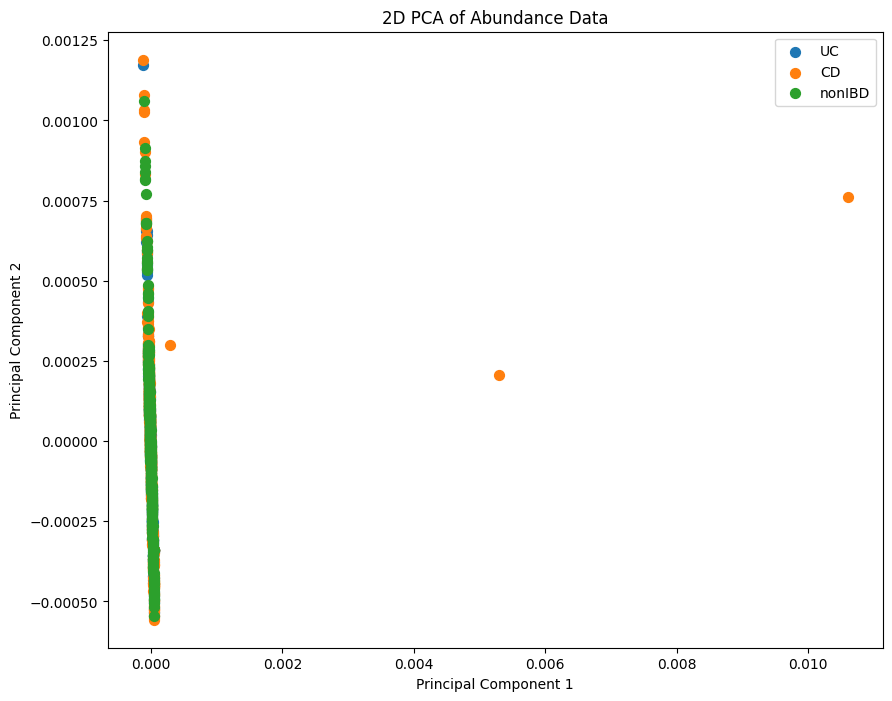

DistanceMatrixError: Data must be symmetric and cannot contain NaNs.

In [12]:
# Filter columns that start with 'DL-endo'
X = merged_df.drop(columns=['sample_id', 'diagnosis'])

# Target variable
y = merged_df['diagnosis']

# Perform PCA with 2 components for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['diagnosis'] = y.values

# Plot the PCA results in 2D
plt.figure(figsize=(10, 8))
for diagnosis in pca_df['diagnosis'].unique():
    indices = pca_df['diagnosis'] == diagnosis
    plt.scatter(pca_df.loc[indices, 'PC1'], pca_df.loc[indices, 'PC2'], label=diagnosis, s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Abundance Data')
plt.legend()
plt.show()

from scipy.spatial.distance import pdist, squareform
# Prepare data for PERMANOVA
# Calculate Bray-Curtis distance matrix
bray_curtis_distance = pdist(X, metric='braycurtis')
distance_matrix = DistanceMatrix(squareform(bray_curtis_distance), ids=merged_df['sample_id'])

# Perform PERMANOVA
permanova_results = permanova(distance_matrix, y, permutations=999)
print(permanova_results)